## Goal
Apply Logistic Regression on Amazon Food reviews
1. Featurize/Vectorize - BoW, tfIDF, Average Word2Vec, tfIDF Word2Vec
2. Train/Test split using time based slicing as a 70-30 split
3. Try L1 regularizer, L2 regularizer and L1 and L2 regularier (ElasticNet)
4. Check for multicollinearity with train data.
5. Increase lambda and report train/test error and sparsity
6. Get Feature Importance


### Data
The Amazon fine food reviews dataset is available [here](https://www.kaggle.com/snap/amazon-fine-food-reviews/downloads/database.sqlite/2). The SQLLite version(database.sqlite) of the dataset is used. A folder called 'amazon-fine-food-reviews' needs to be created in the working directory and downloaded to that folder.

Google Word2Vec (GoogleNews-vectors-negative300.bin) is also used and those are available [here](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer, CountVectorizer
from sklearn.metrics import confusion_matrix, f1_score, classification_report, make_scorer, roc_curve, auc
from sklearn import metrics
from sklearn.decomposition import TruncatedSVD

import itertools, pickle, random, sqlite3, nltk, string, re
from pathlib import Path
from scipy import sparse
import scipy as sp

import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec, KeyedVectors
from tqdm import tqdm
from datetime import datetime, timedelta

d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


### Load Data

In [3]:
# using the SQLite Table to read data.
con = sqlite3.connect('./amazon-fine-food-reviews/database.sqlite') 

#filtering only positive and negative reviews i.e. 
# not considering those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

In [4]:
# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#change reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print ('Total number of reviews is {} with {} features each'.format(*filtered_data.shape))
filtered_data.head()

Total number of reviews is 525814 with 10 features each


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


### EDA

#### Remove Duplicates

In [5]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)

#### Data Cleanup

In [6]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


positive    307061
negative     57110
Name: Score, dtype: int64

#### Note:
The dataset is imbalanced. So the metric to evaluate the model should not be accuracy, it could be confusion matrix 

### PreProcessing

#### Stemming, Stop word remove and Lemmatization

In [7]:
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print('The stop words are \n {}'.format(stop))
print('************************************************************')
print('The stem word for tasty is {}'.format(sno.stem('tasty')))

The stop words are 
 {'this', 'myself', 'how', "shouldn't", 'any', 'no', 'o', 'be', 'of', 'with', 'does', 'me', "couldn't", 'because', 'off', 'which', 'doesn', 'that', 'each', 'we', "needn't", 'our', 'a', 'he', "doesn't", 'these', 'm', "won't", 'same', "isn't", 'themselves', 'such', 'both', 't', 'yours', 'wouldn', 'only', 'mightn', "you're", 'ours', 'did', 'most', "that'll", 'isn', 'own', "weren't", "don't", 'what', 'ourselves', 'there', 'it', 'against', 'you', 'if', "wasn't", 'is', 'why', 'are', 'out', 'theirs', 'mustn', 'needn', 'ain', "shan't", 'should', 'by', 'his', 'who', 'am', 'my', 'about', 'below', 'more', 'ma', 'while', 'her', 'those', 'here', 'or', 'shouldn', 'other', 'll', 'some', 'before', "should've", 'd', 'to', 'couldn', 'then', 'whom', 'your', 'over', 'himself', 'him', 'in', 'into', 'as', 'were', 're', 'few', 'further', 'shan', 'up', 'under', "mustn't", 'until', "she's", 'than', 'aren', 'weren', 'hers', 'has', 'once', 'all', 'now', 'having', 'they', 'on', 'when', 'the', 

We need 3 types of cleaned data so we will use 3 different variables to store this data:
1. For Bag of Words and TfIDF we need the stop words to be removed and stemmed
2. For Bigrams and trigrams we do not need to remove the stop words but we can stem the words
3. For Avg Word2Vec and TfIDF Word2Vec we can remove the stopwords but not stem the words if we plan to use Google's word2vec model.

In [10]:
i=0
str_b=' '
str_n=' '
str_w=' '
bow_tfidf_string=[]
ngrams_string=[]
word2vec_string=[]
s=''
for sent in final['Text'].values:
    filtered_sentence_b=[]
    filtered_sentence_n=[]
    filtered_sentence_w=[]
    
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)): 
                s=(sno.stem(cleaned_words.lower())).encode('utf8')
                filtered_sentence_n.append(s) #for ngrams we need stemmed words
                if(cleaned_words.lower() not in stop):
                    filtered_sentence_b.append(s) #for BoW and tfidf we need stemmed and stop words removed data
                    filtered_sentence_w.append(cleaned_words.lower().encode('utf8')) # for Word2Vec we need non stemmed and stop words removed data
                else:
                    continue
            else:
                continue 
    
    
    str_n = b" ".join(filtered_sentence_n)
    str_b = b" ".join(filtered_sentence_b)
    str_w = b" ".join(filtered_sentence_w)
    
    bow_tfidf_string.append(str_b)
    ngrams_string.append(str_n)
    word2vec_string.append(str_w)

    i+=1

In [11]:
final['BowTfIDFText']=bow_tfidf_string 
final['BowTfIDFText']=final['BowTfIDFText'].str.decode("utf-8")

# final['nGramsText']=ngrams_string 
# final['nGramsText']=final['nGramsText'].str.decode("utf-8")

final['Word2VecText']=word2vec_string 
final['Word2VecText']=final['Word2VecText'].str.decode("utf-8")

In [12]:
# store final table into an SQlLite table for future.
final_dbconn = sqlite3.connect('./amazon-fine-food-reviews/finaldb.sqlite')
c=final_dbconn.cursor()
final_dbconn.text_factory = str
final.to_sql('Reviews', final_dbconn,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

### Time Based Slicing
The below function creates a cross validation dataset and fits the model. This will be used across BoW, tfIDF, Average Word2Vec and tfIDF Word2Vec

In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          figsize = (5,3),
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)

#     plt.figure(figsize=(4,2))
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
    
def fit_predict(estimator, X_train, y_train, X_test, y_test):
    # fitting the model on crossvalidation train
    estimator.fit(X_train, y_train)

    # predict the response on the crossvalidation train
    y_pred = estimator.predict(X_test)
    
    return y_pred

### Run Classifier
Given a dataset of X, y the below function
1. Splits the dataset into train and test.

In [3]:
def split_data(data, sort_by_time='Y', test_size=0.3):
    
    if sort_by_time == 'Y':
        data = data.sort_values(by='Time')
        data.reset_index(inplace=True,drop=True)
        
    train_index = int(np.floor(data.shape[0] * (1- test_size)))

    X_train = data.loc[:train_index]
    y_train = X_train.Score
    X_train.drop(['Score'], axis=1, inplace=True)
    

    X_test = data.loc[train_index:]
    y_test = X_test.Score
    X_test.drop(['Score'], axis=1, inplace=True)
    
    return X_train, y_train, X_test, y_test

In [4]:
def print_impact_of_increasing_C(Cs, X_train, y_train, X_test, y_test):
    info = {}

    for C in Cs:
        model = LogisticRegression(penalty= 'l1', C=C, class_weight='balanced', random_state=42, verbose=1,
                                   warm_start=True, n_jobs=-1)
        model.fit(X_train, y_train)
        #Get all w's to understand how many are non zeros. As we increase C we expect the model to overfit, so the sparsity should
        # also increase
        w = model.coef_
        non_zeros = np.count_nonzero(w)

        #Train & test error
        train_error = model.score(X_train, y_train)
        test_error = model.score(X_test, y_test)

        info[C] = {'sparsity': np.count_nonzero(w), 'train_error': train_error, 'test_error': test_error}

    print("\n\nAs we increase 'C' we expect the model to overfit, so the sparsity should also increase")
    print ('-'*90)
    for key, value in info.items():
        print ('When C is {}, the test error is {}, train error is {} and sparsity is {}'.format(key, \
                                                            value['train_error'], value['test_error'], value['sparsity']))


In [5]:
def plot_cv_scores(gridsearch, param, x_axis_label, y_axis_label, title):
    X = [params[param] for params in gridsearch.cv_results_['params']]
    y = [mean for mean in gridsearch.cv_results_['mean_test_score']]
    
    plt.plot(X, y)
    plt.xlabel(x_axis_label)
    plt.ylabel(y_axis_label)
    
    plt.title(title)
    plt.grid() 

    plt.show()

In [6]:
def plot_roc_curve(fpr, tpr, roc_auc, y_label, x_label):
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.show()

In [7]:
def do_paramSearch(model, param_grid, type_of_search, X_train, y_train, X_test, y_test, cv):
    if type_of_search not in ['GridSearch', 'RandomSearch']:
        print ('Allowed searches are GridSearch and RandomSearch')
        return
    
    #Use TimeSeriesSplit for cross validation
    tscv = TimeSeriesSplit(n_splits=cv)
    
    train_test_split = tscv.split(X_train)

    f1_scorer = make_scorer(f1_score, pos_label='positive')
    if type_of_search == 'GridSearch':
        gs = GridSearchCV(model, param_grid, cv = train_test_split, n_jobs=-1,verbose=5, scoring=f1_scorer)
    elif type_of_search == 'RandomSearch':
        gs = RandomizedSearchCV(model, param_grid, cv = train_test_split, n_jobs=-1,verbose=5, scoring=f1_scorer)
               
    gs.fit(X_train, y_train)
    
    print ('Calculating best score from grid search...')
    print ('Best score: ', gs.best_score_)

    print ('Best parameters set:')
    best_parameters = gs.best_estimator_.get_params()
    for param_name in sorted(param_grid.keys()):
        print (param_name, best_parameters[param_name])
        
    plot_cv_scores(gridsearch=gs, param='C', x_axis_label='C - Inverse of Lambda', y_axis_label='F1 Scores',\
                   title='Plot of CV F1 Scores')

    print ('Dimensions of X_test is {} and y_test is {}'.format (X_test.shape, y_test.shape))
    print ('Predicting with X_test.....')
    y_pred = gs.predict(X_test)

    print ('Classification report is .....')
    print (classification_report(y_test, y_pred))
    
    print ('Confusion Matrix is .....')
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, ['Negative', 'Positive'])
    
    #Calculate probabilities to use to plot roc curve
    y_pred = gs.predict_proba(X_test)

    #keep probability for the positive outcome only
    y_pred = y_pred[:, 1]

    # calculate the fpr and tpr for all thresholds of the classification
    fpr, tpr, threshold = roc_curve(y_test, y_pred, pos_label='positive')

    roc_auc = auc(fpr, tpr)
    print ('ROC Curve is .....')

    y_label= 'True Positive Rate'
    x_label='False Positive Rate'

    plot_roc_curve(fpr, tpr, roc_auc, y_label, x_label)

In [8]:
def get_top_n_features(w, feat_names, top_n=10):
    #Take the absolute weights
    abs_weights = np.abs(w)

    #Get the index in ascending order
    i=np.argsort(-abs_weights)
    #Get the top_n index
    top_n_index = i[:,0:top_n]
    print ('Top n index is ', top_n_index)

    # top_n_index contains list of list, so pop to get the list
    i = list(top_n_index).pop()
    
    #i is a an array so convert it to a list
    list_i = list(i)
    top_n_feats = [feat_names[list_i[n]] for n in range(0, len(list_i))]
    print ('Top {} features are {}'. format(top_n, top_n_feats))

In [9]:
def check_for_multicollinearity(X_train, y_train, penalty, feat_names):
    # Steps to check for multicollnearity:
    # 1. Train the model
    # 2. Store the weight vectors
    # 3. Add some noise to the training data and train it once again.
    # 4. Store the weight vectors
    # 5. Check whether there are large differences in weights, say 30 to 40% difference. 
    # 6. If there is then the data is multicollinear and the weights cannot be used for feature importance.
    
    C=0.01
    model = LogisticRegression(penalty= penalty, C=C, class_weight='balanced', random_state=42, verbose=1,
                                   warm_start=True, n_jobs=-1)
    model.fit(X_train, y_train)
    w1 = model.coef_
    
    #Pertubate X_train 
    noise = 0.01
    X_train.data = X_train.data + noise
    model = LogisticRegression(penalty= penalty, C=C, class_weight='balanced', random_state=42, verbose=1,
                                   warm_start=True, n_jobs=-1)
    model.fit(X_train, y_train)
    w2 = model.coef_
    
    arr1=(w2/w1)
    #calculate mean across the different features/columns
    arr2 = np.mean(arr1, axis=0)
    
    #check whether any element has increased by 40%
    arr3 = arr2[arr2>4.0]
    if len(arr3) > 0: 
        print ('\nDataset is multicollinear')
    else:
        print ('\nDataset is not multicollinear')

    get_top_n_features(w1, feat_names, top_n=10)

In [10]:
def run_classifier(data, vectorize_technique, k=5):
    if vectorize_technique not in ['bow', 'tfidf', 'Gavgw2v', 'Gtfidfw2v', 'Oavgw2v', 'Otfidfw2v']:
        print ('Allowed vectorization techniques are Bag Of Words(bow), TF-IDF(tfidf), \
                Average Word2Vec Using Google vectors(Gavgw2v), TF-IDF Word2Vec Using Google vectors(Gtfidfw2v), \
                Average Word2Vec Using Own Model(Oavgw2v), TF-IDF Word2Vec Using Own Model(Otfidfw2v)')
        return
    
    
    X_train, y_train, X_test, y_test = split_data(data, sort_by_time='Y')
    
    #Create X_train with just the vectors
    if vectorize_technique == 'bow':
        X_train, X_test, vectorizer = vectorize_bow(X_train, X_test)
    elif vectorize_technique == 'tfidf':
        X_train, X_test, vectorizer = vectorize_tfidf(X_train, X_test)
    elif vectorize_technique == 'Gavgw2v':
        X_train, X_test = vectorize_Gavgw2v(X_train, X_test)
    elif vectorize_technique == 'Gtfidfw2v':
        X_train, X_test = vectorize_Gavgw2v(X_train, X_test)
    elif vectorize_technique == 'Oavgw2v':
        X_train, X_test = vectorize_Oavgw2v(X_train, X_test)
    elif vectorize_technique == 'Otfidfw2v':
        X_train, X_test = vectorize_Otfidfw2v(X_train, X_test)
        
    cv = 10
    Cs = [10**-5, 10**-4, 10**-3, 10**-2, 10**-1, 10**0]

    sp.random.seed(123345)
    uniform_Cs=sp.random.uniform(low=10**-4,high=10**0,size=10)

    print_impact_of_increasing_C(Cs, X_train, y_train, X_test, y_test)
    
    regularizers = ['l1', 'l2']
#     type_of_search = ['GridSearch', 'RandomSearch']
    
    type_of_search = 'GridSearch'
    for regularizer in regularizers:
        model = LogisticRegression(penalty= regularizer, class_weight='balanced', random_state=42, verbose=1,
                                   warm_start=True, n_jobs=-1)
        #Do GridSearch
        param_grid = {'C': Cs}
        type_of_search = 'GridSearch'
        print ('\nDoing {} with {} Regularizer.....'.format(type_of_search, regularizer))
        print ('-' *80)
        do_paramSearch(model, param_grid, type_of_search, X_train, y_train, X_test, y_test, cv)
        
        #Do RandomSearch
        # for L2 the param_grid should be from a uniform distribution
        param_grid = {'C': uniform_Cs}
        type_of_search = 'RandomSearch'
        print ('\nDoing {} with {} Regularizer.....'.format(type_of_search, regularizer))
        print ('-' *80)
        do_paramSearch(model, param_grid, type_of_search, X_train, y_train, X_test, y_test, cv)
        
        if vectorize_technique in ['bow', 'tfidf']:
            #Check for multicollienarity
            print ('\nChecking for multicollinearity with {} Regularizer.....'.format(regularizer))
            print ('-' *80)
            #feat_names is used to get the top n useful features
            feat_names = vectorizer.get_feature_names()
            check_for_multicollinearity(X_train, y_train, regularizer, feat_names)

## Bag of Words

In [11]:
def get_bow_tfidfdata(no_of_records = 2000):
    #The original dataset has approximately 85% positive reviews and 15% negative reviews, so we will use the same % to make
    #a subset 
    pos_limit = int(no_of_records * 0.85)
    neg_limit = no_of_records - pos_limit

    final_dbconn = sqlite3.connect('./amazon-fine-food-reviews/finaldb.sqlite')
    final_dbconn.text_factory = str

    pos_qry = "SELECT time, BowTfIDFText, Score FROM Reviews where Score = 'positive' LIMIT " + str(pos_limit)
    pos_reviews = pd.read_sql_query(pos_qry, final_dbconn) 
    print('Positive reviews shape is {}'.format(pos_reviews.shape))

    neg_qry = "SELECT time, BowTfIDFText, Score FROM Reviews where Score = 'negative' LIMIT " + str(neg_limit)
    neg_reviews = pd.read_sql_query(neg_qry, final_dbconn) 
    print('Negative reviews shape is {}'.format(neg_reviews.shape))

    frames = [pos_reviews, neg_reviews]

    data = pd.concat(frames, ignore_index=True)
    print('Both positive and negative reviews combined together contains {} reviews'.format(data.shape[0]))
    return data

In [12]:
def run_svd(X_train_cnts, X_test_cnts, reduce_to):
    svd = TruncatedSVD(n_components=reduce_to)

    print ('Shape of X train cnts before SVD is {}'.format(X_train_cnts.shape))
    X_train_red = svd.fit_transform(X_train_cnts)
    print ('Shape of X train cnts after SVD is {}'.format(X_train_red.shape))
    explained_ratio = svd.explained_variance_ratio_
    print ('The explained ratio with {} components is {}'.format(reduce_to, np.sum(explained_ratio)))
    
    X_test_red = svd.fit_transform(X_test_cnts)
    return X_train_red, X_test_red

def vectorize_bow(X_train, X_test):
    #Vectorize the reviews
    count_vect = CountVectorizer() 
    
    #Build vocabulary from X_train
    X_train_counts = count_vect.fit_transform(X_train['BowTfIDFText'].values)
    X_test_counts = count_vect.transform(X_test['BowTfIDFText'].values)
    
    print("Shape of vectorized train and test datasets are {} and {}".format(X_train_counts.get_shape(), X_test_counts.get_shape()) )
    print("Number of unique words in the dataset is ", X_train_counts.get_shape()[1])
    print ('Type of bow_counts ', type(X_train_counts))
    
    X_train_std_data = StandardScaler(with_mean = False).fit_transform(X_train_counts)
    print ('Type of std_bow_data is {}'.format(type(X_train_std_data)))
    print ('Standardized Bag of Words review contains {} records with {} features each'.format(*X_train_std_data.shape))

    #vectorize the test set with the same vocabulary as train data set
    print("The shape of our BOW vectorized test dataset is {}".format(X_test_counts.get_shape()))

    X_test_std_data = StandardScaler(with_mean = False).fit_transform(X_test_counts)
    return X_train_std_data, X_test_std_data, count_vect

Positive reviews shape is (307061, 3)
Negative reviews shape is (54626, 3)
Both positive and negative reviews combined together contains 361687 reviews
Shape of vectorized train and test datasets are (253181, 58985) and (108507, 58985)
Number of unique words in the dataset is  58985
Type of bow_counts  <class 'scipy.sparse.csr.csr_matrix'>


d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Type of std_bow_data is <class 'scipy.sparse.csr.csr_matrix'>
Standardized Bag of Words review contains 253181 records with 58985 features each
The shape of our BOW vectorized test dataset is (108507, 58985)


d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

As we increase 'C' we expect the model to overfit, so the sparsity should also increase
------------------------------------------------------------------------------------------
When C is 1e-05, the test error is 0.14815487734071672, train error is 0.15774097523662067 and sparsity is 0
When C is 0.0001, the test error is 0.6980974085733131, train error is 0.6951348760909435 and sparsity is 36
When C is 0.001, the test error is 0.878264956691063, train error is 0.8732063369183555 and sparsity is 1332
When C is 0.01, the test error is 0.9287189797022684, train error is 0.8920438312735584 and sparsity is 16007
When C is 0.1, the test error is 0.9396321208937479, train error is 0.880044605417162 and sparsity is 29469
When C is 1, the test error is 0.9397466634542087, train error is 0.87382380860221 and sparsity is 35650

Doing GridSearch with l1 Regularizer.....
--------------------------------------------------------------------------------
Fitting 10 folds for each of 6 can

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  58 out of  60 | elapsed:  4.2min remaining:    8.7s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  4.3min finished
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]Calculating best score from grid search...
Best score:  0.9336007269831587
Best parameters set:
C 0.01


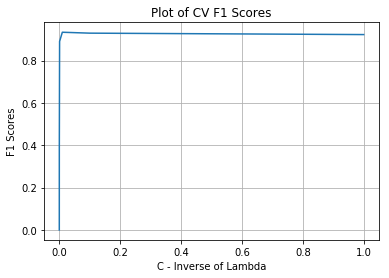

Dimensions of X_test is (108507, 58985) and y_test is (108507,)
Predicting with X_test.....
Classification report is .....
             precision    recall  f1-score   support

   negative       0.61      0.85      0.71     17116
   positive       0.97      0.90      0.93     91391

avg / total       0.91      0.89      0.90    108507

Confusion Matrix is .....


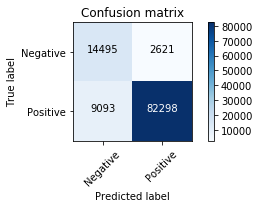

ROC Curve is .....


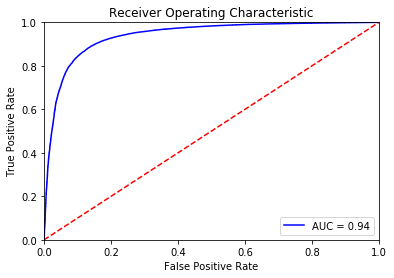


Doing RandomSearch with l1 Regularizer.....
--------------------------------------------------------------------------------
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 22.6min finished
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]Calculating best score from grid search...
Best score:  0.9339864100520119
Best parameters set:
C 0.0146141028376181


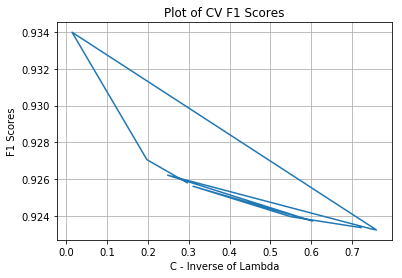

Dimensions of X_test is (108507, 58985) and y_test is (108507,)
Predicting with X_test.....
Classification report is .....
             precision    recall  f1-score   support

   negative       0.61      0.84      0.71     17116
   positive       0.97      0.90      0.93     91391

avg / total       0.91      0.89      0.90    108507

Confusion Matrix is .....


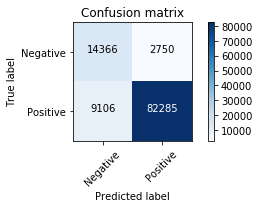

ROC Curve is .....


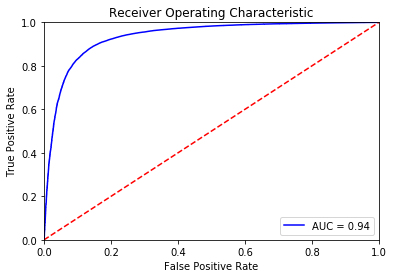


Checking for multicollinearity with l1 Regularizer.....
--------------------------------------------------------------------------------


d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]
Dataset is multicollinear
Top n index is  [[22230  4825 30320 13530 38499 21737 17609 14534 34948 18380]]
Top 10 features are ['great', 'best', 'love', 'delici', 'perfect', 'good', 'excel', 'disappoint', 'nice', 'favorit']

Doing GridSearch with l2 Regularizer.....
--------------------------------------------------------------------------------
Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  58 out of  60 | elapsed: 10.3min remaining:   21.2s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 11.2min finished
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]Calculating best score from grid search...
Best score:  0.9369742164661875
Best parameters set:
C 0.0001


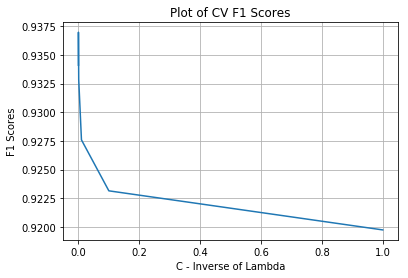

Dimensions of X_test is (108507, 58985) and y_test is (108507,)
Predicting with X_test.....
Classification report is .....
             precision    recall  f1-score   support

   negative       0.62      0.83      0.71     17116
   positive       0.97      0.91      0.94     91391

avg / total       0.91      0.89      0.90    108507

Confusion Matrix is .....


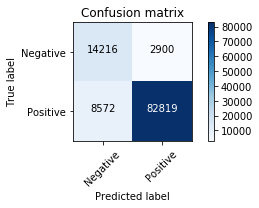

ROC Curve is .....


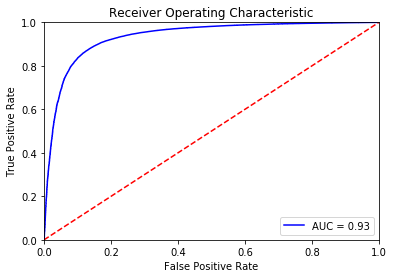


Doing RandomSearch with l2 Regularizer.....
--------------------------------------------------------------------------------
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 21.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 40.8min finished
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]Calculating best score from grid search...
Best score:  0.9267935211093349
Best parameters set:
C 0.0146141028376181


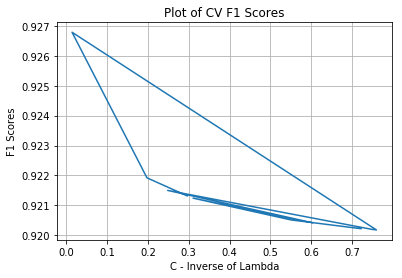

Dimensions of X_test is (108507, 58985) and y_test is (108507,)
Predicting with X_test.....
Classification report is .....
             precision    recall  f1-score   support

   negative       0.58      0.78      0.67     17116
   positive       0.96      0.89      0.92     91391

avg / total       0.90      0.88      0.88    108507

Confusion Matrix is .....


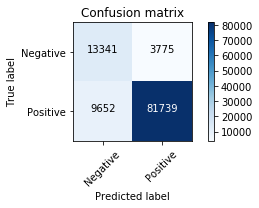

ROC Curve is .....


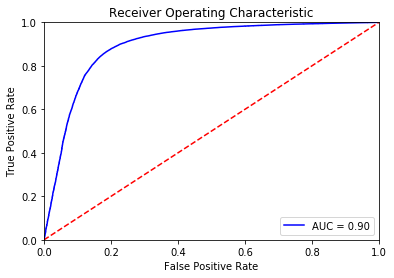


Checking for multicollinearity with l2 Regularizer.....
--------------------------------------------------------------------------------


d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]
Dataset is multicollinear
Top n index is  [[22230  4825 30320 13530 38499 21737 17609 14534 34948 18380]]
Top 10 features are ['great', 'best', 'love', 'delici', 'perfect', 'good', 'excel', 'disappoint', 'nice', 'favorit']
02:50:50


In [13]:
no_of_records=364171
# no_of_records=1000
data = get_bow_tfidfdata(no_of_records)
run_classifier(data, vectorize_technique ='bow')
ist = datetime.now()
print (format(ist, '%H:%M:%S'))

## TF-IDF

In [14]:
def vectorize_tfidf(X_train, X_test):
    #Vectorize the reviews
    tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
    
    #Build vocabulary from X_train
    X_train_counts = tf_idf_vect.fit_transform(X_train['BowTfIDFText'].values)
    X_test_counts = tf_idf_vect.transform(X_test['BowTfIDFText'].values)
    
    print("Shape of vectorized train and test datasets are {} and {}".format(X_train_counts.get_shape(), X_test_counts.get_shape()) )
    print("Number of unique words in the dataset is ", X_train_counts.get_shape()[1])
    print ('Type of bow_counts ', type(X_train_counts))
    
    X_train_std_data = StandardScaler(with_mean = False).fit_transform(X_train_counts)
    print ('Type of std_bow_data is {}'.format(type(X_train_std_data)))
    print ('Standardized Bag of Words review contains {} with {} features each'.format(*X_train_std_data.shape))
    
    #vectorize the test set with the same vocabulary as train data set
    print("The shape of vectorized test dataset is {}".format(X_test_counts.get_shape()))
    
    X_test_std_data = StandardScaler(with_mean = False).fit_transform(X_test_counts)
    return X_train_std_data, X_test_std_data, tf_idf_vect

Positive reviews shape is (307061, 3)
Negative reviews shape is (54626, 3)
Both positive and negative reviews combined together contains 361687 reviews
Shape of vectorized train and test datasets are (253181, 2296819) and (108507, 2296819)
Number of unique words in the dataset is  2296819
Type of bow_counts  <class 'scipy.sparse.csr.csr_matrix'>
Type of std_bow_data is <class 'scipy.sparse.csr.csr_matrix'>
Standardized Bag of Words review contains 253181 with 2296819 features each
The shape of vectorized test dataset is (108507, 2296819)


d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

As we increase 'C' we expect the model to overfit, so the sparsity should also increase
------------------------------------------------------------------------------------------
When C is 1e-05, the test error is 0.14815487734071672, train error is 0.15774097523662067 and sparsity is 0
When C is 0.0001, the test error is 0.7134658603923675, train error is 0.7140737463942418 and sparsity is 44
When C is 0.001, the test error is 0.8961651940706451, train error is 0.8885970490383109 and sparsity is 14816
When C is 0.01, the test error is 0.9996405733447613, train error is 0.9279954288663405 and sparsity is 92813
When C is 0.1, the test error is 0.999976301539215, train error is 0.9257375100223949 and sparsity is 105371
When C is 1, the test error is 0.999976301539215, train error is 0.9275069811164257 and sparsity is 144696

Doing GridSearch with l1 Regularizer.....
--------------------------------------------------------------------------------
Fitting 10 folds for each of 

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  58 out of  60 | elapsed:  5.3min remaining:   10.8s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 10.7min finished
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]Calculating best score from grid search...
Best score:  0.9511322386705403
Best parameters set:
C 0.01


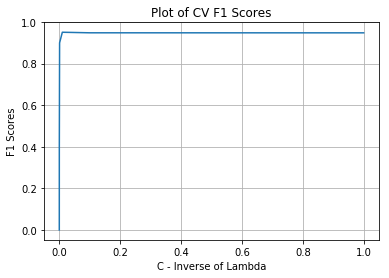

Dimensions of X_test is (108507, 2296819) and y_test is (108507,)
Predicting with X_test.....
Classification report is .....
             precision    recall  f1-score   support

   negative       0.81      0.71      0.76     17116
   positive       0.95      0.97      0.96     91391

avg / total       0.93      0.93      0.93    108507

Confusion Matrix is .....


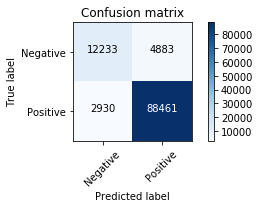

ROC Curve is .....


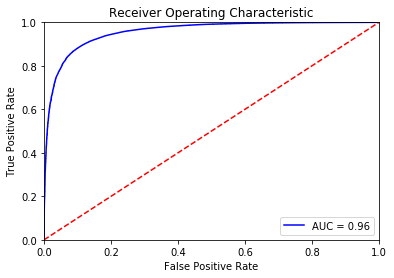


Doing RandomSearch with l1 Regularizer.....
--------------------------------------------------------------------------------
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 11.4min finished
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]Calculating best score from grid search...
Best score:  0.9504249269129574
Best parameters set:
C 0.0146141028376181


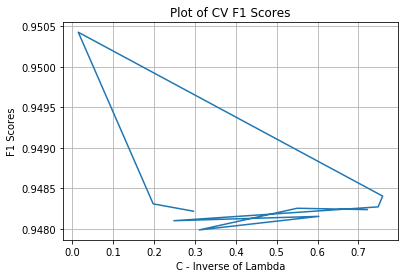

Dimensions of X_test is (108507, 2296819) and y_test is (108507,)
Predicting with X_test.....
Classification report is .....
             precision    recall  f1-score   support

   negative       0.81      0.70      0.75     17116
   positive       0.95      0.97      0.96     91391

avg / total       0.92      0.93      0.93    108507

Confusion Matrix is .....


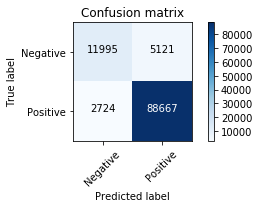

ROC Curve is .....


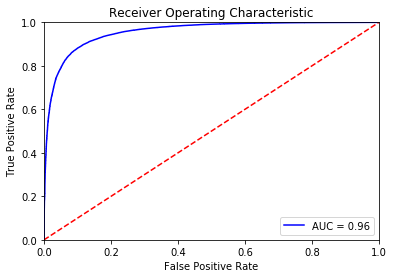


Checking for multicollinearity with l1 Regularizer.....
--------------------------------------------------------------------------------


d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]
Dataset is multicollinear
Top n index is  [[ 890754 1182551  178427  531189 1471581  568359  868612  686275  959101
   728456]]
Top 10 features are ['great', 'love', 'best', 'delici', 'perfect', 'disappoint', 'good', 'excel', 'high recommend', 'favorit']

Doing GridSearch with l2 Regularizer.....
--------------------------------------------------------------------------------
Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   36.8s
[Parallel(n_jobs=-1)]: Done  58 out of  60 | elapsed: 28.4min remaining:   58.7s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 29.4min finished
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]Calculating best score from grid search...
Best score:  0.9370526146926017
Best parameters set:
C 1e-05


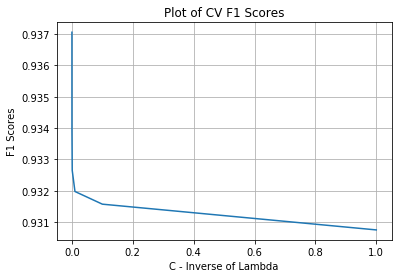

Dimensions of X_test is (108507, 2296819) and y_test is (108507,)
Predicting with X_test.....
Classification report is .....
             precision    recall  f1-score   support

   negative       0.90      0.48      0.63     17116
   positive       0.91      0.99      0.95     91391

avg / total       0.91      0.91      0.90    108507

Confusion Matrix is .....


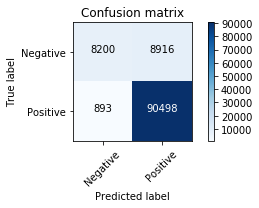

ROC Curve is .....


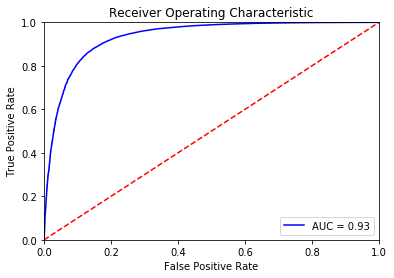


Doing RandomSearch with l2 Regularizer.....
--------------------------------------------------------------------------------
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 39.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 70.1min finished
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]Calculating best score from grid search...
Best score:  0.9318969925991742
Best parameters set:
C 0.0146141028376181


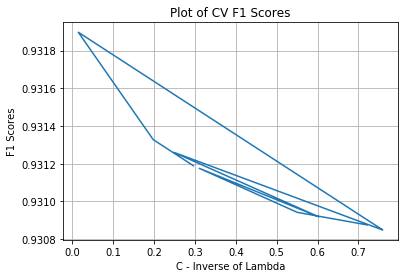

Dimensions of X_test is (108507, 2296819) and y_test is (108507,)
Predicting with X_test.....
Classification report is .....
             precision    recall  f1-score   support

   negative       0.92      0.39      0.55     17116
   positive       0.90      0.99      0.94     91391

avg / total       0.90      0.90      0.88    108507

Confusion Matrix is .....


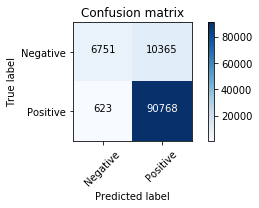

ROC Curve is .....


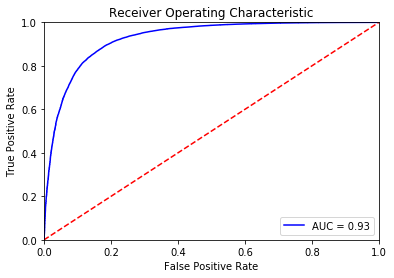


Checking for multicollinearity with l2 Regularizer.....
--------------------------------------------------------------------------------


d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]
Dataset is multicollinear
Top n index is  [[ 890754 1182551  868612  178427  531189  728456  568359  686275 2154216
   748736]]
Top 10 features are ['great', 'love', 'good', 'best', 'delici', 'favorit', 'disappoint', 'excel', 'use', 'find']
05:00:58


In [15]:
no_of_records=364171
# no_of_records=1000
data = get_bow_tfidfdata(no_of_records)
run_classifier(data, vectorize_technique ='tfidf')
ist = datetime.now()
print (format(ist, '%H:%M:%S'))

## Word2Vec
There are 2 ways to do word2vec
1. Use Google's model which was built using Google's news dataset. Since this was built from a large dataset, this gives us a 300 dimension vector which will be richer.
2. Train our own model. Since we have a small dataset, we can build a 50 dimensional vector with this.
We will try both ways below

As a first step we need to build a list of sentence from the Word2VecText we have saved earlier. This will be used to get the vectors from Google's model as well as the one that we are going to build

In [16]:
def get_w2vdata(no_of_records = 2000):
    #The original dataset has approximately 85% positive reviews and 15% negative reviews, so we will use the same % to make
    #a subset 
    pos_limit = int(no_of_records * 0.85)
    neg_limit = no_of_records - pos_limit

    final_dbconn = sqlite3.connect('./amazon-fine-food-reviews/finaldb.sqlite')
    final_dbconn.text_factory = str

    pos_qry = "SELECT time, Word2VecText, Score FROM Reviews where Score = 'positive' LIMIT " + str(pos_limit)
    pos_reviews = pd.read_sql_query(pos_qry, final_dbconn) 
    print('Positive reviews shape is {}'.format(pos_reviews.shape))

    neg_qry = "SELECT time, Word2VecText, Score FROM Reviews where Score = 'negative' LIMIT " + str(neg_limit)
    neg_reviews = pd.read_sql_query(neg_qry, final_dbconn) 
    print('Negative reviews shape is {}'.format(neg_reviews.shape))

    frames = [pos_reviews, neg_reviews]

    data = pd.concat(frames, ignore_index=True)
    print('Both positive and negative reviews combined together contains {} reviews'.format(data.shape[0]))

    return data

#### Train our own Word2Vec model

In [17]:
def build_word2vec(train_list_of_sent):
    # Train your own Word2Vec model using your own text corpus
    w2v_model=Word2Vec(train_list_of_sent,min_count=5,size=50, workers=4)

    w2v_words = list(w2v_model.wv.vocab)
    return w2v_model, w2v_words

#### Average Word2Vec With our own model

In [18]:
def vectorize_Oavgw2v(X_train, X_test):
    train_list_of_sent=[]
    test_list_of_sent=[]
    print ('Splitting train data into sentences.....')
    for sent in X_train['Word2VecText'].values:
        train_list_of_sent.append(sent.split())
    
    print ('Splitting test data into sentences.....')
    for sent in X_test['Word2VecText'].values:
        test_list_of_sent.append(sent.split())
        
    print ('Building our word model.....')
    w2v_model, w2v_words = build_word2vec(train_list_of_sent)

    print ('Vectorizing train data.....')
    print('Starting vectorizing at {}'. format(datetime.now()))
    
    train_sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in train_list_of_sent: # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        train_sent_vectors.append(sent_vec)

    print ('Vectorizing test data.....')
    print('Starting vectorizing at {}'. format(datetime.now()))
    test_sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in test_list_of_sent: # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        test_sent_vectors.append(sent_vec)
    print('Completed vectorizing at {}'. format(datetime.now()))
    
    #convert to sparse matrix
    X_train_counts = sparse.csr_matrix(np.array(train_sent_vectors))
    X_test_counts = sparse.csr_matrix(np.array(test_sent_vectors))
        
    X_train_std_data = StandardScaler(with_mean = False).fit_transform(X_train_counts)
    print ('Type of std_bow_data is {}'.format(type(X_train_std_data)))
    print ('Standardized reviews contain {} with {} features each'.format(*X_train_std_data.shape))
    
    #vectorize the test set with the same vocabulary as train data set
    print("The shape of vectorized test dataset is {}".format(X_test_counts.get_shape()))
    
    X_test_std_data = StandardScaler(with_mean = False).fit_transform(X_test_counts)
    return X_train_std_data, X_test_std_data

Positive reviews shape is (307061, 3)
Negative reviews shape is (54626, 3)
Both positive and negative reviews combined together contains 361687 reviews
Splitting train data into sentences.....
Splitting test data into sentences.....
Building our word model.....
Vectorizing train data.....
Starting vectorizing at 2018-10-19 05:01:24.778310
Vectorizing test data.....
Starting vectorizing at 2018-10-19 05:08:36.819569
Completed vectorizing at 2018-10-19 05:11:52.938608
Type of std_bow_data is <class 'scipy.sparse.csr.csr_matrix'>
Standardized reviews contain 253181 with 50 features each
The shape of vectorized test dataset is (108507, 50)


d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

As we increase 'C' we expect the model to overfit, so the sparsity should also increase
------------------------------------------------------------------------------------------
When C is 1e-05, the test error is 0.14815487734071672, train error is 0.15774097523662067 and sparsity is 0
When C is 0.0001, the test error is 0.7896327133552675, train error is 0.777535089902034 and sparsity is 14
When C is 0.001, the test error is 0.8270881306259158, train error is 0.8199194522012405 and sparsity is 44
When C is 0.01, the test error is 0.8320253099561183, train error is 0.825006681596579 and sparsity is 50
When C is 0.1, the test error is 0.8321990986685415, train error is 0.8311629664445612 and sparsity is 50
When C is 1, the test error is 0.8320529581603675, train error is 0.8324992857603657 and sparsity is 50

Doing GridSearch with l1 Regularizer.....
--------------------------------------------------------------------------------
Fitting 10 folds for each of 6 candidates, 

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  58 out of  60 | elapsed: 22.0min remaining:   45.4s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 23.7min finished
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]Calculating best score from grid search...
Best score:  0.8840672934764524
Best parameters set:
C 1


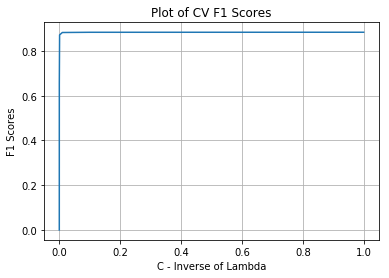

Dimensions of X_test is (108507, 50) and y_test is (108507,)
Predicting with X_test.....
Classification report is .....
             precision    recall  f1-score   support

   negative       0.48      0.85      0.62     17116
   positive       0.97      0.83      0.89     91391

avg / total       0.89      0.83      0.85    108507

Confusion Matrix is .....


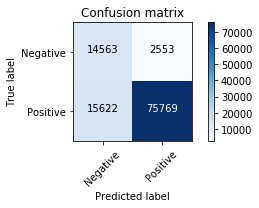

ROC Curve is .....


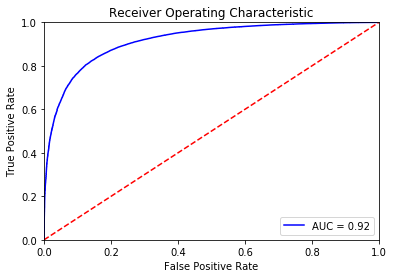


Doing RandomSearch with l1 Regularizer.....
--------------------------------------------------------------------------------
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 63.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 121.7min finished
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]Calculating best score from grid search...
Best score:  0.8840715852052109
Best parameters set:
C 0.748199837462165


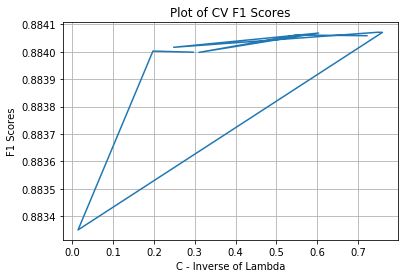

Dimensions of X_test is (108507, 50) and y_test is (108507,)
Predicting with X_test.....
Classification report is .....
             precision    recall  f1-score   support

   negative       0.48      0.85      0.62     17116
   positive       0.97      0.83      0.89     91391

avg / total       0.89      0.83      0.85    108507

Confusion Matrix is .....


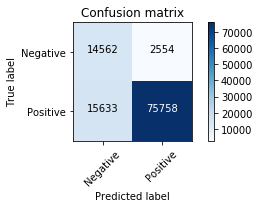

ROC Curve is .....


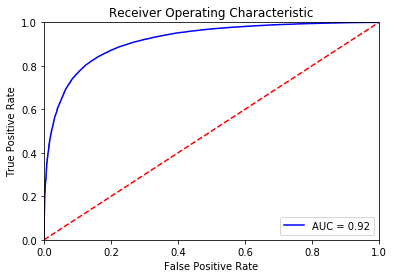


Doing GridSearch with l2 Regularizer.....
--------------------------------------------------------------------------------
Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  58 out of  60 | elapsed:  1.3min remaining:    2.6s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.4min finished
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]Calculating best score from grid search...
Best score:  0.8840628594487849
Best parameters set:
C 1


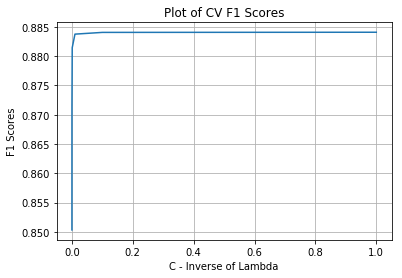

Dimensions of X_test is (108507, 50) and y_test is (108507,)
Predicting with X_test.....
Classification report is .....
             precision    recall  f1-score   support

   negative       0.48      0.85      0.62     17116
   positive       0.97      0.83      0.89     91391

avg / total       0.89      0.83      0.85    108507

Confusion Matrix is .....


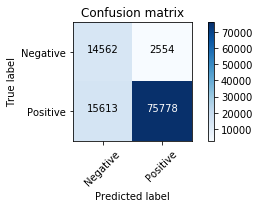

ROC Curve is .....


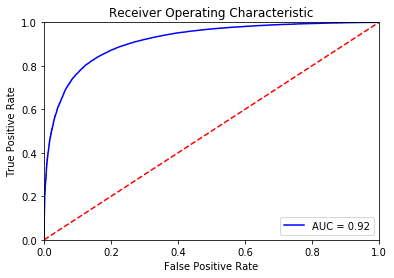


Doing RandomSearch with l2 Regularizer.....
--------------------------------------------------------------------------------
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.4min finished
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]Calculating best score from grid search...
Best score:  0.8840992077272276
Best parameters set:
C 0.6030901742748025


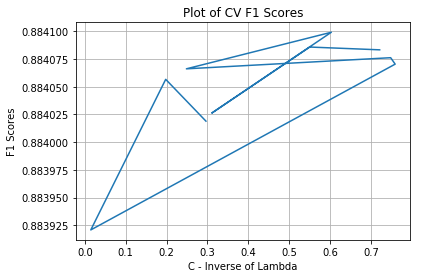

Dimensions of X_test is (108507, 50) and y_test is (108507,)
Predicting with X_test.....
Classification report is .....
             precision    recall  f1-score   support

   negative       0.48      0.85      0.62     17116
   positive       0.97      0.83      0.89     91391

avg / total       0.89      0.83      0.85    108507

Confusion Matrix is .....


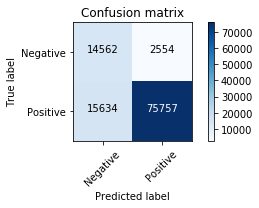

ROC Curve is .....


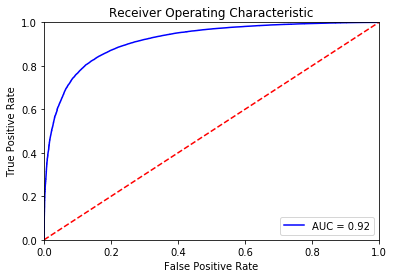

07:51:05


In [19]:
no_of_records=364171
# no_of_records=1000
data = get_w2vdata(no_of_records)
run_classifier(data, vectorize_technique ='Oavgw2v')
ist = datetime.now()
print (format(ist, '%H:%M:%S'))

#### TF-IDF weighted Word2Vec With our own model

In [20]:
def vectorize_Otfidfw2v(X_train, X_test):
    # TF-IDF weighted Word2Vec
    tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
    tf_idf_counts = tf_idf_vect.fit_transform(X_train['Word2VecText'].values)
    
    # we are converting a dictionary with word as a key, and the idf as a value
    dictionary = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))


    tfidf_feat = tf_idf_vect.get_feature_names() 
    
    train_list_of_sent=[]
    test_list_of_sent=[]
    print ('Splitting train data into sentences.....')
    for sent in X_train['Word2VecText'].values:
        train_list_of_sent.append(sent.split())
    
    print ('Splitting test data into sentences.....')
    for sent in X_test['Word2VecText'].values:
        test_list_of_sent.append(sent.split())
        
    print ('Building our word model.....')
    w2v_model, w2v_words = build_word2vec(train_list_of_sent)
    
    print ('Vectorizing train data.....')
    train_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    for sent in train_list_of_sent: # for each review/sentence 
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                # obtain the tf_idfidf of a word in a sentence/review
#                 tf_idf = tf_idf_counts[row, tfidf_feat.index(word)]
                tf_idf = dictionary[word]*sent.count(word)
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        train_sent_vectors.append(sent_vec)
        row += 1

    print ('Vectorizing test data.....')
    test_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    for sent in test_list_of_sent: # for each review/sentence 
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                # obtain the tf_idfidf of a word in a sentence/review
#                 tf_idf = tf_idf_counts[row, tfidf_feat.index(word)]
                tf_idf = dictionary[word]*sent.count(word)
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        test_sent_vectors.append(sent_vec)
        row += 1

    X_train_counts = sparse.csr_matrix(np.array(train_sent_vectors))
    X_test_counts = sparse.csr_matrix(np.array(test_sent_vectors))
        
    X_train_std_data = StandardScaler(with_mean = False).fit_transform(X_train_counts)
    print ('Type of std_bow_data is {}'.format(type(X_train_std_data)))
    print ('Standardized reviews contain {} with {} features each'.format(*X_train_std_data.shape))
    
    #vectorize the test set with the same vocabulary as train data set
    print("The shape of vectorized test dataset is {}".format(X_test_counts.get_shape()))
    
    X_test_std_data = StandardScaler(with_mean = False).fit_transform(X_test_counts)
    return X_train_std_data, X_test_std_data

Positive reviews shape is (307061, 3)
Negative reviews shape is (54626, 3)
Both positive and negative reviews combined together contains 361687 reviews
Splitting train data into sentences.....
Splitting test data into sentences.....
Building our word model.....
Vectorizing train data.....
Vectorizing test data.....
Type of std_bow_data is <class 'scipy.sparse.csr.csr_matrix'>
Standardized reviews contain 253181 with 50 features each
The shape of vectorized test dataset is (108507, 50)


d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]

As we increase 'C' we expect the model to overfit, so the sparsity should also increase
------------------------------------------------------------------------------------------
When C is 1e-05, the test error is 0.14815487734071672, train error is 0.15774097523662067 and sparsity is 0
When C is 0.0001, the test error is 0.7780204675706313, train error is 0.7640152248242049 and sparsity is 17
When C is 0.001, the test error is 0.8094051291368626, train error is 0.7998746624641728 and sparsity is 40
When C is 0.01, the test error is 0.8137419474605124, train error is 0.806749794944105 and sparsity is 47
When C is 0.1, the test error is 0.8135839577219459, train error is 0.8084455380758845 and sparsity is 50
When C is 1, the test error is 0.8134180684964512, train error is 0.8086667219626383 and sparsity is 50

Doing GridSearch with l1 Regularizer.....
--------------------------------------------------------------------------------
Fitting 10 folds for each of 6 candidates,

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  58 out of  60 | elapsed: 11.8min remaining:   24.2s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 12.4min finished
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]Calculating best score from grid search...
Best score:  0.8725299046932082
Best parameters set:
C 0.1


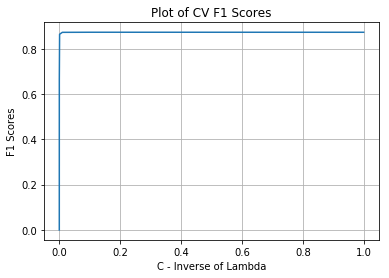

Dimensions of X_test is (108507, 50) and y_test is (108507,)
Predicting with X_test.....
Classification report is .....
             precision    recall  f1-score   support

   negative       0.44      0.84      0.58     17116
   positive       0.96      0.80      0.88     91391

avg / total       0.88      0.81      0.83    108507

Confusion Matrix is .....


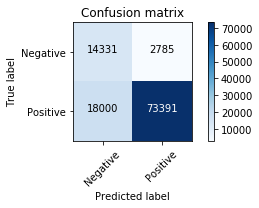

ROC Curve is .....


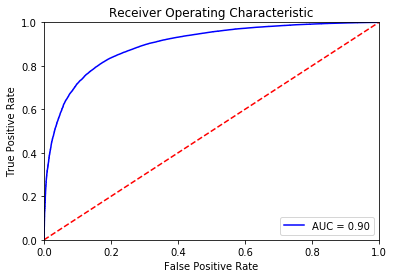


Doing RandomSearch with l1 Regularizer.....
--------------------------------------------------------------------------------
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 31.6min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 58.5min finished
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]Calculating best score from grid search...
Best score:  0.8724546566398481
Best parameters set:
C 0.19785864726006933


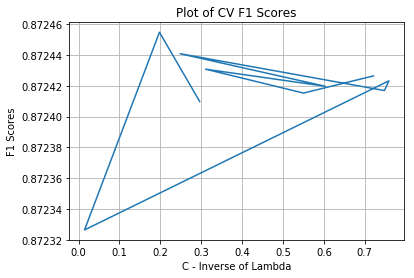

Dimensions of X_test is (108507, 50) and y_test is (108507,)
Predicting with X_test.....
Classification report is .....
             precision    recall  f1-score   support

   negative       0.44      0.84      0.58     17116
   positive       0.96      0.80      0.88     91391

avg / total       0.88      0.81      0.83    108507

Confusion Matrix is .....


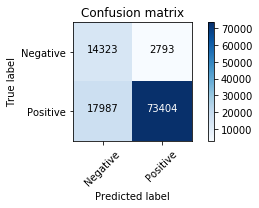

ROC Curve is .....


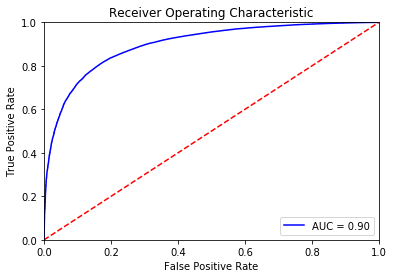


Doing GridSearch with l2 Regularizer.....
--------------------------------------------------------------------------------
Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  58 out of  60 | elapsed:  1.4min remaining:    2.7s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.4min finished
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]Calculating best score from grid search...
Best score:  0.8725950283556735
Best parameters set:
C 0.01


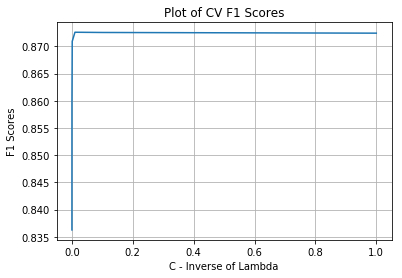

Dimensions of X_test is (108507, 50) and y_test is (108507,)
Predicting with X_test.....
Classification report is .....
             precision    recall  f1-score   support

   negative       0.44      0.84      0.58     17116
   positive       0.96      0.80      0.88     91391

avg / total       0.88      0.81      0.83    108507

Confusion Matrix is .....


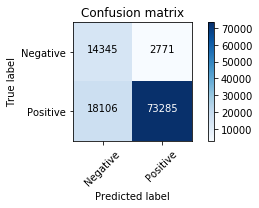

ROC Curve is .....


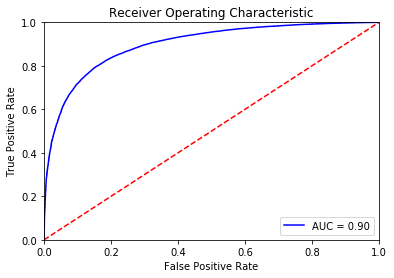


Doing RandomSearch with l2 Regularizer.....
--------------------------------------------------------------------------------
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.9min finished
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[LibLinear]Calculating best score from grid search...
Best score:  0.8726057641693257
Best parameters set:
C 0.0146141028376181


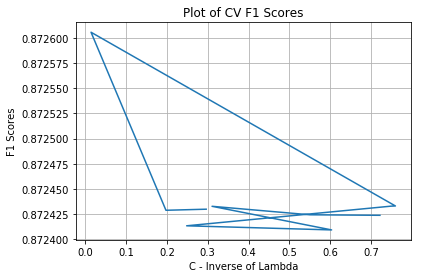

Dimensions of X_test is (108507, 50) and y_test is (108507,)
Predicting with X_test.....
Classification report is .....
             precision    recall  f1-score   support

   negative       0.44      0.84      0.58     17116
   positive       0.96      0.80      0.88     91391

avg / total       0.88      0.81      0.83    108507

Confusion Matrix is .....


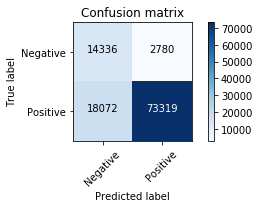

ROC Curve is .....


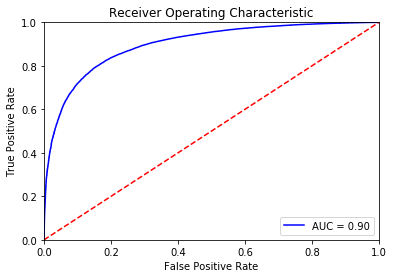

09:22:56


In [21]:
no_of_records=364171
# no_of_records=1000
data = get_w2vdata(no_of_records)
run_classifier(data, vectorize_technique ='Otfidfw2v')
ist = datetime.now()
print (format(ist, '%H:%M:%S'))

### Bag of Words
With Bag of Words the train dataset was not multicolinear

|Regularizer|Hyper Parameter - C |Train Score|Test F1 Score| Top 10 useful words|
| ------------- |:-------------:| -----:|-----:|-----:|
|L1 Regularizer - GridSearch|	0.01|	0.933600727|	0.9|-|
|L1 Regularizer - RandomSearch|		0.014614103|0.93398641|	0.9|'great', 'best', 'love', 'delici', 'perfect', 'good', 'excel', 'disappoint', 'nice', 'favorit'|
|L2 Regularizer - GridSearch|	1.00E-04|	0.936974216|	0.9|-|
|L2 Regularizer - RandomSearch|		0.014614103|0.926793521|	0.88|'great', 'best', 'love', 'delici', 'perfect', 'good', 'excel', 'disappoint', 'nice', 'favorit'|


### TFIDF
With TFIDF the train dataset was not multicolinear

|Regularizer|Hyper Parameter - C |Train Score|Test F1 Score| Top 10 useful words|
| ------------- |:-------------:| -----:|-----:|-----:|
|L1 Regularizer - GridSearch|	0.01|	0.951132239|	0.93|-|
|L1 Regularizer - RandomSearch|	0.014614103|	0.950424927|0.93|'great', 'love', 'best', 'delici', 'perfect', 'disappoint', 'good', 'excel', 'high recommend', 'favorit'|		
|L2 Regularizer - GridSearch|	1.00E-05|	0.937052615|	0.9|-|
|L2 Regularizer - RandomSearch|	0.014614103|	0.931896993|0.88|'great', 'love', 'good', 'best', 'delici', 'favorit', 'disappoint', 'excel', 'use', 'find'|		

### AverageWord2Vec

|Regularizer|Hyper Parameter - C |Train Score|Test F1 Score| 
| ------------- |:-------------:| -----:|-----:|
|L1 Regularizer - GridSearch|	1|	0.883235959|	0.85|
|L1 Regularizer - RandomSearch|	0.248492807|	0.883229803|0.85|
|L2 Regularizer - GridSearch|	1|	0.883246001|	0.85|
|L2 Regularizer - RandomSearch|	0.197858647|0.883255559|0.85|

### TFIDFWeightedWord2Vec

|Regularizer|Hyper Parameter - C |Train Score|Test F1 Score| 
| ------------- |:-------------:| -----:|-----:|
|L1 Regularizer - GridSearch|	0.1|	0.869998626|	0.83|
|L1 Regularizer - RandomSearch|	0.197858647|	0.869973164|0.83|
|L2 Regularizer - GridSearch|	0.01|	0.870204704|	0.83|
|L2 Regularizer - RandomSearch|	0.014614103|	0.870262095|0.83|
